
# <center>Problem 1</center>



 <center>Fubraury 17, 2019 </center>


##### Author:

**Dehgan Arthur** :    20088465  
**Sghir Hamza**   :    20147626     
**Adrien Mainka** :    20130281  



In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import os
import sys
import struct
import math
import time

# Data Preparation

Test, train and validation sets

In [137]:
data = np.load('mnist.npz')

X_train = data['x_train'][:48000].reshape(48000, 784)
y_train = data["y_train"][:48000]
X_valid = data['x_train'][48000:].reshape(12000, 784)
y_valid = data["y_train"][48000:]

X_test = data['x_test'].reshape(10000, 784)
y_test = data['y_test']

In [ ]:
d0 = 28 * 28
d1 = 490
d2 = 450
d3 = 10

n_parameters = d0 * d1 + d1 + d1 * d2 + d2 + d2 * d3 + d3
print('Total number of parameters: %d' % n_parameters)

# Building the Model


In [25]:
class Classifier:


    def __init__(self, init_method, input_size = 784, n1=650 , n2=450, output_size = 10, 
                 hidden_dims=(490,490), n_hidden=2, mode='train'):

        if init_method == "normal":
            W1 = np.random.normal(size=(n1, input_size))
            W2 = np.random.normal(size=(n2, n1))
            W3 = np.random.normal(size=(output_size, n2))
        elif init_method == "zeros":
            W1 = np.zeros(shape=(n1, input_size))
            W2 = np.zeros(shape=(n2, n1))
            W3 = np.zeros(shape=(output_size, n2))
        elif init_method == "glorot":
            d1 = math.sqrt(6 / (input_size+n1))
            d2 = math.sqrt(6 / (n1 + n2))
            d3 = math.sqrt(6 / (n2 + output_size))
            W1 = np.random.uniform(-d1, d1, size=(n1, input_size))
            W2 = np.random.uniform(-d2, d2,size=(n2, n1))
            W3 = np.random.uniform(-d3, d3,size=(output_size, n2))
        
        elif init_method=="load":
            pass
        else:
            raise ValueError("init must be 'normal', 'zeros' or 'glorot'")

        b1 = np.zeros((n1))
        b2 = np.zeros((n2))
        b3 = np.zeros((output_size))
        
        self.Params = {'W1':W1, 'b1':b1,
                       'W2':W2, 'b2':b2,
                       'W3':W3, 'b3':b3}


    def forward(self, x, y):
                
        h1 = np.dot(x, self.Params['W1'].T) + self.Params['b1']
        h1_cache=(x, self.Params['W1'], self.Params['b1'], h1)
        a1, a1_cache = self.relu_forward(h1)
        
        h2=np.dot(a1, self.Params['W2'].T) + self.Params['b2']
        h2_cache=(a1, self.Params['W2'], self.Params['b2'], h2)
        a2, a2_cache = self.relu_forward(h2)

        scores=np.dot(a2, self.Params['W3'].T) + self.Params['b3']
        scores_cache=(a2, self.Params['W3'], self.Params['b3'],scores )
        preds = np.argmax(scores, axis=1)
        softmax_loss, dsoftmax = self.softmax_loss(scores, y)
        self.cache = ( h1_cache, a1_cache, h2_cache, a2_cache, scores_cache, dsoftmax)
        return preds, softmax_loss

    def backward(self, x, weight_decay=0):
        
        ( h1_cache, a1_cache, h2_cache, a2_cache, scores_cache, dsoftmax) = self.cache
        (x, w, b, out) = scores_cache
        da2 = np.dot(dsoftmax, w)
        dW3 = np.dot(dsoftmax.T, x) / x.shape[0]
        db3 = dsoftmax.sum(axis=0) / x.shape[0]
        
        dh2= ((a2_cache > 0) * da2)
        
        (x, w, b, out) = h2_cache
        da1 = np.dot(dh2, w)
        dW2 = np.dot(dh2.T, x) / x.shape[0]
        db2 = dh2.sum(axis=0) / x.shape[0]
        
        
        dh1= ((a1_cache > 0) * da1)

        
        (x, w, b, out) = h1_cache
        dW1 = np.dot(dh1.T, x) / x.shape[0]
        db1 = dh1.sum(axis=0) / x.shape[0]
        

        dW3 += weight_decay * self.Params['W3']
        dW2 += weight_decay * self.Params['W2']
        dW1 += weight_decay * self.Params['W1']

        grads = {'W1':dW1, 'b1':db1,
                 'W2':dW2, 'b2':db2,
                 'W3':dW3, 'b3':db3}
        return grads

    def relu_forward(self, x):
        return np.maximum(0, x), x

    def softmax_loss(self, x, y):

        shifted_logits = x - np.max(x, axis=1, keepdims=True)
        Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
        log_probs = shifted_logits - np.log(Z)
        probs = np.exp(log_probs)
        N = x.shape[0]
        loss = -np.sum(log_probs[np.arange(N), y]) / N
        dsof = probs.copy()
        dsof[np.arange(N), y] -= 1
        dsof /= N
        return loss, dsof

    def train(self, data, target, mb_size=64, learning_rate=1e-4, weight_decay=0.):
        for i in range(math.ceil(data.shape[0] / mb_size)):
            
            xi = data[i*mb_size:(i+1)*mb_size]
            yi = target[i*mb_size:(i+1)*mb_size]
            y, loss = self.forward(xi, yi)
            average_grads = self.backward(xi,weight_decay)
            average_loss = loss
            
            for param, grad in average_grads.items():
                self.Params[param] -= learning_rate * grad
        return average_loss

    def test(self, x, y):
        preds, softmax_loss = self.forward(x, y)
        return softmax_loss, preds
    
    def check_grad_w2(self,x , y, index, epsilon ):
        self.forward(x,y)
        grad = self.backward(x)
        
        i = math.floor(index / self.Params["W2"].shape[1])
        j = index % self.Params["W2"].shape[1]
        grad = grad["W2"][i][j]
        
        self.Params["W2"][i][j] += epsilon
        _, l1 = self.forward(x,y)
        
        self.Params["W2"][i][j] -=  2 *epsilon
        _, l2 = self.forward(x,y)
        
        self.Params["W2"][i][j] += epsilon
#         print("grad {}  l1 {}   l2 {}".format(grad,l1,l2))
        
        return abs( ( (l1 - l2) / (2.* epsilon) ) - grad)

#### Running accuracy parameters

In [139]:
def run_parameters(init_method, num_epochs,mb_size,learning_rate,  hidden_layer1, hidden_layer2):
    mlp = MLP(init_method = init_method, n1 = hidden_layer1, n2 = hidden_layer2)
    train_accu = []
    train_losses = []
    valid_accu = []
    valid_losses = []


    for e in range(num_epochs):
        loss = mlp.train(X_train, y_train, mb_size, learning_rate)

        loss_train, pred_train = mlp.test(X_train, y_train)
        loss_valid, pred_valid = mlp.test(X_valid, y_valid)

        valid_losses.append(loss_valid)

        valid_accu.append((pred_valid == y_valid).mean())
        acc_val=(pred_valid == y_valid).mean()
        
        train_losses.append(loss_train)

        acc_train=(pred_train == y_train).mean()
        train_accu.append((pred_train == y_train).mean())
        
        #print("val acc"+ str(acc_val) + "epoch :" + str(e))
        #print("train acc"+ str(acc_train)+ "epoch :" + str(e))
        #print("Epoch "+str(e)+"/"+str(num_epochs)+"  |  "+ "Val accuracy :"+'{:.3f}'.format(acc_train) +"  |  "+"Val accuracy :"+'{:.3f}'.format(acc_val))

    return acc_train, acc_val

#### Running loss (cross entropy)

In [140]:
def run_loss(init_method, num_epochs,mb_size,learning_rate,  hidden_layer1, hidden_layer2):
    start = time.time()
    mlp = Classifier(init_method = init_method, n1 = hidden_layer1, n2 = hidden_layer2)
    train_losses = []
    valid_losses = []
    glob_time= time.time()
    for e in range(num_epochs):
        loss = mlp.train(X_train, y_train, mb_size, learning_rate)

        loss_train, pred_train = mlp.test(X_train, y_train)
        loss_valid, pred_valid = mlp.test(X_valid, y_valid)

        valid_losses.append(loss_valid)
        
        train_losses.append(loss_train)
     
    
        runtime = time.time() - start
    
        print("Epoch "+str(e)+"/"+str(num_epochs)+"  |  "+ "loss :"+'{:.3f}'.format(loss_valid)+"  |  "+  '%.3f minutes\n' % (runtime / 60.0) )
    #total_time= time.time() - glob_time
    print('%s executed in %.3f minutes\n' % (init_method, runtime / 60.0))
    plt.plot(range(0,num_epochs ), valid_losses, label="Val loss")
    plt.plot(range(0,num_epochs), train_losses, label="train loss")
    #plt.plot(range(0, 10), loss_f, label="loss")
    plt.legend(title=init_method)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
    
    return train_losses



# Initialization

### Network parameters


hidden_dims = (650, 450)  
n_hidden = 2  
batchsize = 64  
lr = .01  
weight_decay = 0  
activation = "ReLU"

#### Zero Initialization

Epoch 0/10  |  loss :2.303  |  0.753 minutes

Epoch 1/10  |  loss :2.303  |  1.306 minutes

Epoch 2/10  |  loss :2.303  |  1.807 minutes

Epoch 3/10  |  loss :2.302  |  2.282 minutes

Epoch 4/10  |  loss :2.302  |  2.730 minutes

Epoch 5/10  |  loss :2.302  |  3.153 minutes

Epoch 6/10  |  loss :2.302  |  3.587 minutes

Epoch 7/10  |  loss :2.302  |  4.019 minutes

Epoch 8/10  |  loss :2.302  |  4.449 minutes

Epoch 9/10  |  loss :2.302  |  4.892 minutes

zeros executed in 4.892 minutes



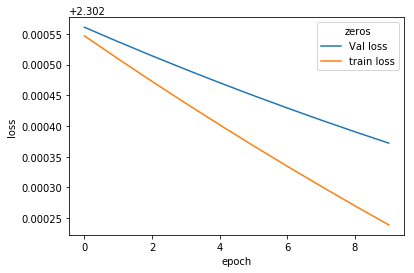

In [142]:
loss_zero=[]
loss_zero= run_loss(init_method = "zeros", num_epochs=10,mb_size = 64,learning_rate= 1e-2, hidden_layer1 = 650, hidden_layer2=450)


#### Normal Initialization

Epoch 0/10  |  loss :49.392  |  0.483 minutes

Epoch 1/10  |  loss :27.562  |  0.966 minutes

Epoch 2/10  |  loss :21.238  |  1.447 minutes

Epoch 3/10  |  loss :20.867  |  1.928 minutes

Epoch 4/10  |  loss :19.370  |  2.419 minutes

Epoch 5/10  |  loss :17.303  |  2.905 minutes

Epoch 6/10  |  loss :17.181  |  3.393 minutes

Epoch 7/10  |  loss :18.024  |  3.876 minutes

Epoch 8/10  |  loss :15.442  |  4.388 minutes

Epoch 9/10  |  loss :15.155  |  4.867 minutes

normal executed in 4.867 minutes



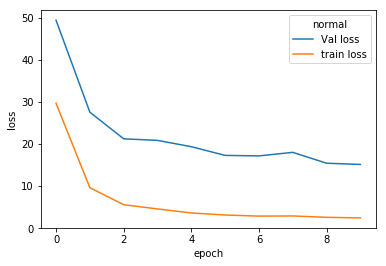

In [143]:
loss_normal=[]
loss_normal= run_loss(init_method = "normal", num_epochs=10,mb_size = 64,learning_rate= 1e-2,  hidden_layer1 = 650, hidden_layer2=450)


#### Glorit Initialization

Epoch 0/10  |  loss :1.807  |  0.503 minutes

Epoch 1/10  |  loss :1.341  |  1.006 minutes

Epoch 2/10  |  loss :1.211  |  1.521 minutes

Epoch 3/10  |  loss :1.105  |  2.030 minutes

Epoch 4/10  |  loss :1.002  |  2.535 minutes

Epoch 5/10  |  loss :0.983  |  3.033 minutes

Epoch 6/10  |  loss :0.936  |  3.547 minutes

Epoch 7/10  |  loss :0.926  |  4.066 minutes

Epoch 8/10  |  loss :0.906  |  4.578 minutes

Epoch 9/10  |  loss :0.875  |  5.081 minutes

glorot executed in 5.081 minutes



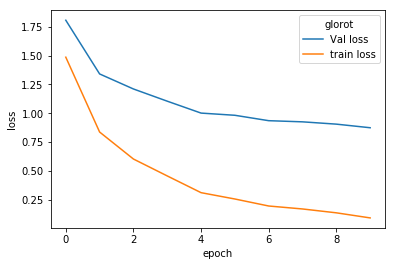

In [144]:
loss_glorot=[]
loss_glorot= run_loss(init_method = "glorot", num_epochs=10,mb_size = 64,learning_rate= 1e-2,  hidden_layer1 = 650, hidden_layer2=450)

##### Loss Comparison

Comparison of the loss on training data depending on the training time and initialization
method. 

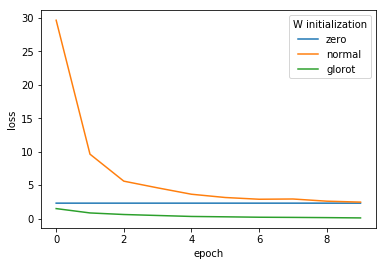

In [145]:
plt.plot(range(0, 10), loss_zero, label="zero")
plt.plot(range(0, 10), loss_normal, label="normal")
plt.plot(range(0, 10), loss_glorot, label="glorot")
plt.legend(title="W initialization")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

The loss value for one epoch is the average value of loss obtained through the epoch.
In fact, The loss rate remains high with zero and normal initialization and the MLP cannot correctly classify. However, with Glorot initialization,the gradients can correctly optimize the loss

# Hyperparameter Search

Set up a grid of hyperparameter values and select random combinations to train the model and score

In [114]:
import random
from prettytable import PrettyTable

t = PrettyTable(['epoch', 'learning_rate','hidden1', 'hidden2','mini batch size','train accuracy','val accuracy'])

def random_search(num_search):

    for i in range(num_search):
        # Random initialization of hyper-parameters
        dim_l1 = random.choice([450,500,650])
        dim_l2 = random.choice([450,400])
        learning_rate = random.choice([1e-2, 0.05])

        mini_batch_size= random.choice([32,25])
        epochs= random.choice([10,12])
        
        # Creation and training of the NN
        train_accu, valid_accu= run_parameters(init_method = "glorot", num_epochs=epochs,mb_size = mini_batch_size,learning_rate= learning_rate, hidden_layer1 = dim_l1, hidden_layer2=dim_l2)

        t.add_row([epochs,learning_rate,dim_l1,dim_l2,mini_batch_size,train_accu,valid_accu])
        print(t)


In [115]:
random_search(10)

+-------+---------------+---------+---------+-----------------+--------------------+--------------+
| epoch | learning_rate | hidden1 | hidden2 | mini batch size |   train accuracy   | val accuracy |
+-------+---------------+---------+---------+-----------------+--------------------+--------------+
|   10  |      0.05     |   500   |   450   |        32       | 0.9997291666666667 |   0.95925    |
+-------+---------------+---------+---------+-----------------+--------------------+--------------+
+-------+---------------+---------+---------+-----------------+--------------------+--------------------+
| epoch | learning_rate | hidden1 | hidden2 | mini batch size |   train accuracy   |    val accuracy    |
+-------+---------------+---------+---------+-----------------+--------------------+--------------------+
|   10  |      0.05     |   500   |   450   |        32       | 0.9997291666666667 |      0.95925       |
|   10  |      0.05     |   650   |   450   |        32       |       0.9995

+-------+---------------+---------+---------+-----------------+--------------------+--------------------+
| epoch | learning_rate | hidden1 | hidden2 | mini batch size |   train accuracy   |    val accuracy    |
+-------+---------------+---------+---------+-----------------+--------------------+--------------------+
|   10  |      0.05     |   500   |   450   |        32       | 0.9997291666666667 |      0.95925       |
|   10  |      0.05     |   650   |   450   |        32       |       0.9995       | 0.9603333333333334 |
|   10  |      0.05     |   500   |   400   |        32       | 0.9984583333333333 |       0.958        |
|   10  |      0.01     |   500   |   400   |        32       | 0.9993333333333333 |        0.95        |
|   12  |      0.01     |   500   |   450   |        25       |        1.0         |       0.956        |
|   10  |      0.05     |   650   |   450   |        25       | 0.9988333333333334 | 0.9644166666666667 |
|   10  |      0.05     |   650   |   450   | 

Our best hyper-parameters 

In [125]:
import random
from prettytable import PrettyTable

t = PrettyTable(['epoch', 'learning_rate','hidden1', 'hidden2','mini batch size','train accuracy','val accuracy'])

def random_search(num_search):

    for i in range(num_search):
        # Random initialization of hyper-parameters
        dim_l1 = random.choice([650])
        dim_l2 = random.choice([450])
        learning_rate = random.choice([0.05])

        mini_batch_size= random.choice([20])
        epochs= random.choice([20])
        
        # Creation and training of the NN
        train_accu, valid_accu= run_parameters(init_method = "glorot", num_epochs=epochs,mb_size = mini_batch_size,learning_rate= learning_rate, hidden_layer1 = dim_l1, hidden_layer2=dim_l2)

        t.add_row([epochs,learning_rate,dim_l1,dim_l2,mini_batch_size,train_accu,valid_accu])
        print(t)


In [124]:
random_search(1)

+-------+---------------+---------+---------+-----------------+--------------------+--------------------+
| epoch | learning_rate | hidden1 | hidden2 | mini batch size |   train accuracy   |    val accuracy    |
+-------+---------------+---------+---------+-----------------+--------------------+--------------------+
|   20  |      0.05     |   650   |   450   |        20       | 0.9995416666666667 | 0.9679166666666666 |
+-------+---------------+---------+---------+-----------------+--------------------+--------------------+


We are able to obtain an accuracy higher than 96.79% on the validation set using MLP with 2 hidden layers of 650 and 450 units. We use a learning rate of 0.05, a SGD with a batch size of 32, ReLU activation functions for the hidden layers, and a
cross-entropy loss.

# Validate Gradients using Finite Difference

In [4]:
# read the data
data = pd.read_csv("../mnist_train.csv")
X = data.values[:,1:]/255
Y = data.values[:,0]

In [46]:
model3 = Classifier(init_method="glorot")

In [51]:
N = []
diff_grad = []
for i in range(0,4):
    for k in [1,5]:
        N.append(k*10**i)
        diff_grad.append(max([model3.check_grad_w2(X[50:51],Y[50:51], index, 1/(k*10**i)) for index in range(10) ] ) )
        
        

Text(0, 0.5, '$log_{10}(\\max_{1 \\leq i \\leq p} |\\nabla^N_i - \\frac{\\partial L}{\\partial \\theta_i}|) $\t\t\t\t\t')

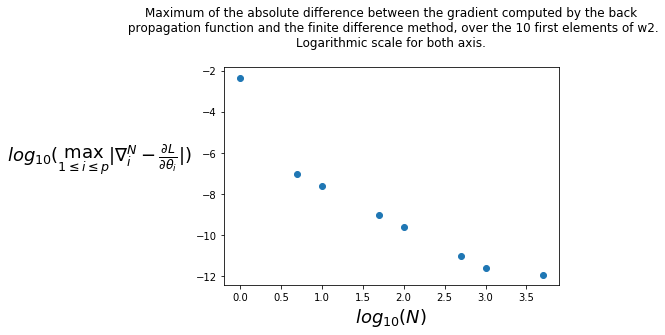

In [57]:
plt.scatter(np.log10(N),np.log10(diff_grad))
plt.title("Maximum of the absolute difference between the gradient computed by the back\n propagation function and the finite difference method, over the 10 first elements of w2.\nLogarithmic scale for both axis.\n")
plt.xlabel("$log_{10}( N )$",fontsize=18)
plt.ylabel("$log_{10}(\\max_{1 \\leq i \\leq p} |\\nabla^N_i - \\frac{\\partial L}{\\partial \\theta_i}|) $"+5*"\t", rotation=0, fontsize=18)

As we can see, as $N$ increases, and consequently $\epsilon = \frac{1}{N}$ decreases $\max_{1 \leq i \leq p} |\nabla^N_i - \frac{\partial L}{\partial \theta_i}| $ decreases and tends to zero. This shows that we compute well the gradient.